In [1]:
import numpy as np
import GPy
import datetime
import CBOopt
import matplotlib.pyplot as plt
from scipy import interpolate
from epics import caget, caput
import time

#from Tools_Class import Beam_Image_Tools


In [6]:
def set_act(mots, motpos, timeout = 60):
    for i, mot in enumerate(mots):
        caput(mot + ':MOT.VAL', motpos[i])
    time.sleep(0.1)
    mov = True
    while mov:
        status = 0
        for mot in mots:
            status = status + (caget(mot + ':MOT.DMOV') - 1)
        mov = bool(status)
        time.sleep(0.1)
        timeout -= 0.1
        if timeout <= 0:
            print('TIMEOUT:   ({} s) while moving motors'.format(timeout))
            return False
    return True
        
def get_motpos(mots):
    motpos = []
    for mot in mots:
        motpos.append(caget(mot + ':MOT.RBV'))
    return motpos

# Send motor position and get integrate camera value
def cost(x):
    mot = ['TWLHA-LMOT-MW33']
    set_act(mot, [x])
    #time.sleep(5)
    # avg = 100
    #val = (caget('TWLHA-LCAM-C103:AVE_WFM') - 5.4E6) / 2E7
    val = (caget('TWLHA-LCAM-C101:INTEGRAL_AVE') - 3.5E5) / 6E6
    y_new = np.array([val])
    
    #val = val[-avg:]
    #print(val[-50:])
    #print(np.mean(val), np.std(val))
    # y_new = np.array([np.mean(val)])
    # plt.plot(val)
    '''
    
    with open('Beam_Transmission_1D.npy', 'rb') as f:
        f = np.load(f)
    # xval = f[0]
    y = f[1]
    s = interpolate.InterpolatedUnivariateSpline(x_val, y)
    y_new = s(x)
    '''
    
    return -y_new

In [7]:
cost(4753)

array([-0.844449])

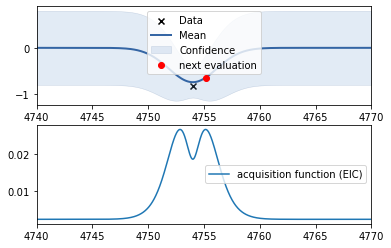

optimizer  [4752.85699329]  found with EIC  0.026655147766885556


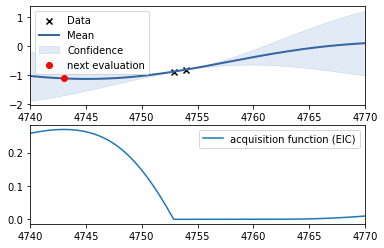

optimizer  [4743.04225006]  found with EIC  0.2690263750459202


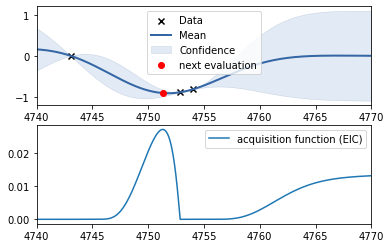

optimizer  [4751.30393298]  found with EIC  0.027262221181445584


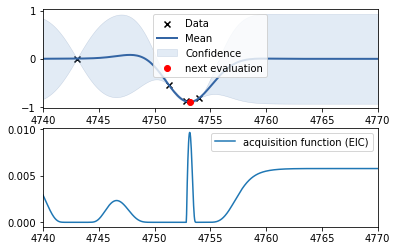

optimizer  [4753.15543998]  found with EIC  0.009678708695517938


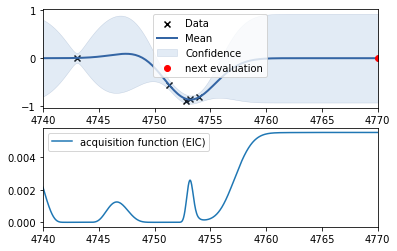

optimizer  [4770.]  found with EIC  0.005496233860553561
the optimal cost value  [-0.884873] was found at input  [4752.85699329]
The number of constraint violations was  0
violations at  []
with constraint values []
the optimization has evaluated  0  repetitiones


In [18]:

# if __name__ == '__main__':
# Bayesian optimization parameters
dim_x = 1 # optimization dimension
beta = 3 # confidence parameter (default = 3 ~99% confidence)
# x_sample = x_sample()
d_min = np.array([4740]) # domain lower bound
d_max = np.array([4770]) # domain upper bound
discretization = np.array([0.01])
d_min_safe = np.array([4740]) # safe boundaries for initial samples
d_max_safe = np.array([4770])
iterlim = 20 # max number of iterations
constrlim = np.array([None]) # constraint limit (if the cost itself is not constrained use None)
stop_eic_abs = 0.1 # EIC termination level
#init = CBOopt.LHCsample(1, dim_x, d_min_safe, d_max_safe)
init = np.array([[4754]])
filename = "CBOoptimization"
timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M') # Time stamp for data storage
optimization_method = "PSO"
update_hyperparameters_flag = True
safe_flag = False

# Evaluate initial set
samples = init.copy()
val = cost(samples[0])
values = np.array([val])

for i in range(1,samples.shape[0]):
    val = cost(samples[i])
    values = np.vstack((values,val))

# Build up GP(s) for cost function and additional constraints
# GP kernel
RBF = GPy.kern.RBF(input_dim=dim_x, lengthscale=[2.15], variance=0.15) # squared exponential kernel (k(x,x'))
#RBF.lengthscale.constrain_bounded(0.1, 10, warning=False) # lengthscale bounds for hyperparameter tuning
#RBF.variance.constrain_bounded(0.1, 10, warning=False) # variance bounds for hyperparameter tuning

# Prior mean constant
# mf_gp0 = GPy.mappings.Constant(dim_x, 1, constrlim[0])  # prior mean (constant mean prior mu_0(x))

# Prior mean function handle
# mf_gp0 = GPy.core.Mapping(dim_x, 1)
# mf_gp0.f = cost
# mf_gp0.update_gradients = lambda a, b: None

# cost GP
gp0 = GPy.core.GP(samples, values, RBF, GPy.likelihoods.Gaussian(variance=0.015))

# GoOSE main
# create GoOSE instance
gps = [gp0]
opt = CBOopt.CBOopt(gps, constrlim, d_min, d_max, stop_eic_abs=stop_eic_abs)
#opt.update_hyperparameters()
i = values.shape[0] # current iteration

x_sample = np.linspace(d_min[0], d_max[0], num = 1001)

while i < iterlim and opt.stopcount < 3:
    # plot GP
    fig, (ax1, ax2) = plt.subplots(2, 1)
    pl = opt.gps[0].plot(plot_limits=[d_min[0], d_max[0]], ax=ax1)

    # plot acquisition function
    EIC_t = opt.EIC(np.expand_dims(x_sample, axis=1))
    ax2.plot(x_sample, EIC_t,label="acquisition function (EIC)")
    ax2.set_xlim([d_min[0], d_max[0]])
    #ax2.set_ylim([-0.1, 0.75])

    # plot next point to evaluate
    i_next = np.argmax(EIC_t)
    EIC_next = EIC_t[i_next]
    mean_next, var_next = opt.gps[0].predict(np.atleast_2d(x_sample[i_next]))
    mean_next = mean_next.squeeze()
    ax1.plot(x_sample[i_next], mean_next, "ro",label="next evaluation")
    # plot show
    ax1.legend()
    ax2.legend()
    plt.show(block=False)
    plt.pause(1)
    
    file_title = "Plot_{}".format(i)
    fig.savefig(file_title)
    plt.close()

    # Calculate optimizer
    if optimization_method == "PSO":
        x_opt, eic = opt.get_optimizer_PSO(100)
    elif optimization_method == "grid evaluation":
        x_opt, eic = opt.get_optimizer_grideval(discretization)
    else:
        print("undefined optimization method: ", optimization_method)
        raise()
    print("optimizer ", x_opt, " found with EIC ", eic)
    # Evaluate optimizer
    val = cost(x_opt)
    y = np.array([val[0]])
    opt.add_new_data_point(x_opt,y)
    if update_hyperparameters_flag is True:
        opt.update_hyperparameters()
    i = i+1

# Results
# All valid points fulfilling the constraints, boolean array
valid_points = np.all(opt.y[:,opt.flag_mainc:] < opt.constrlim[opt.flag_mainc:],axis=1)
# Optimal cost of valid evaluated points
optimal_observed_value = opt.best
# Optimal iteration
optimal_i = opt.best_idx
# All valid input parameters evaluated
valid_inputs = opt.x[valid_points==1,:]
# Best input parameters evaluated
optimal_input = valid_inputs[optimal_i,:]
# Number of infeasible evaluations (violation of at least 1 constraint)
num_if_points = opt.y.shape[0] - valid_inputs.shape[0]
# All invalid inputs
invalid_inputs = opt.x[valid_points==0,:]
# Observed constraint values of invalid inputs
violations = opt.y[valid_points==0,opt.flag_mainc:]
# Delete repetitions from inputs, to count them
unique_inputs = np.unique(opt.x,axis=0)

# Save results
if safe_flag is True:
    opt.save_data(filename,timestamp,source=None)

print("the optimal cost value ",optimal_observed_value,"was found at input ",optimal_input)
print("The number of constraint violations was ",num_if_points)
print("violations at ",invalid_inputs)
print("with constraint values",violations)
print("the optimization has evaluated ", (opt.y.shape[0] - unique_inputs.shape[0]), " repetitiones")


In [ ]:
x_sample = np.linspace(d_min[0], d_max[0])

In [13]:
RBF